# Spelling Bee

In this notebook we train a Neural Network to recognise Japanese phonemes based on MFCCs with 200 ms in length.

## 1 Imports, Variables and Functions

Install libraries

In [1]:
#!pip install keras==2.0.5
#!pip install librosa
!pip install scipy
!pip install h5py==2.7.0

In [25]:
import scipy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import os
#import librosa as lr
import shutil
import dask.array as da
from dask.array.image import imread
import h5py
import glob

from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Cropping2D, Embedding, Convolution2D, Lambda, InputLayer
from keras.layers import Dropout, Input, BatchNormalization, LSTM, TimeDistributed, GRU, Activation, Reshape
from keras.layers.merge import add, concatenate
from keras.optimizers import Nadam, SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

In [47]:
input_dim = (1, 36, 44)
output_dim = 106

batch_size = 32
data_size = int(72863)

train_size = int(72745)
validate_size = 300
test_size = 300

Convert a directory of images to a HDF5 file storing the images in an array. The shape of the array will be (img_num, height, width[, channels]).

In [4]:
def jpgs_to_h5(source, target, name):
    imgs = imread(source + '*.jpg')
    imgs.to_hdf5(target, name)

## 2 Preparing the data

Covert the folder of images to a compressed container file

In [5]:
#import zipfile
#zip_ref = zipfile.ZipFile('JPGS.zip', 'r')
#zip_ref.extractall('./data/')
#zip_ref.close()

In [6]:
jpgs_to_h5('data/jpg/', 'data/data.h5', 'data')

Shuffle the data and split it into train, valid and test

In [7]:
y = pd.read_csv('data/train_list.csv')['Phonetics']
y = pd.get_dummies(y)
print(y)
y = y.reindex_axis(sorted(y.columns), axis=1)
y = y.values
y = da.from_array(y, chunks=1000)
print(y)

       a  ba  be  bi  bo  bu  bya  byo  byu  cha ...  wi  wo  xtsu  ya  yo  \
0      1   0   0   0   0   0    0    0    0    0 ...   0   0     0   0   0   
1      1   0   0   0   0   0    0    0    0    0 ...   0   0     0   0   0   
2      1   0   0   0   0   0    0    0    0    0 ...   0   0     0   0   0   
3      1   0   0   0   0   0    0    0    0    0 ...   0   0     0   0   0   
4      1   0   0   0   0   0    0    0    0    0 ...   0   0     0   0   0   
5      1   0   0   0   0   0    0    0    0    0 ...   0   0     0   0   0   
6      1   0   0   0   0   0    0    0    0    0 ...   0   0     0   0   0   
7      1   0   0   0   0   0    0    0    0    0 ...   0   0     0   0   0   
8      1   0   0   0   0   0    0    0    0    0 ...   0   0     0   0   0   
9      1   0   0   0   0   0    0    0    0    0 ...   0   0     0   0   0   
10     1   0   0   0   0   0    0    0    0    0 ...   0   0     0   0   0   
11     1   0   0   0   0   0    0    0    0    0 ...   0   0    

In [48]:
x = h5py.File('data/data.h5')['data']
x = da.from_array(x, chunks=1000)
x

dask.array<array-7..., shape=(73345, 36, 44), dtype=uint8, chunksize=(1000, 36, 44)>

In [49]:
shfl = np.random.permutation(data_size)
shfl[0]

tr_idx = shfl[:train_size]
va_idx = shfl[train_size:train_size+validate_size]
te_idx = shfl[train_size+validate_size:]

x[tr_idx].to_hdf5('data/x_tr.h5', 'x_tr')
y[tr_idx].to_hdf5('data/y_tr.h5', 'y_tr')
x[va_idx].to_hdf5('data/x_va.h5', 'x_va')
y[va_idx].to_hdf5('data/y_va.h5', 'y_va')
x[te_idx].to_hdf5('data/x_te.h5', 'x_te')
y[te_idx].to_hdf5('data/y_te.h5', 'y_te')

IndexError: Index out of bounds 72863

## 3 Load and process the data

Read the data we've prepared and check its dimensions

In [17]:
x_tr = da.from_array(h5py.File('data/x_tr.h5')['x_tr'], chunks=1000)
x_tr = x_tr.reshape(x_tr.shape[0], 1, input_dim[1], input_dim[2])
x_tr = x_tr.astype('float32')
y_tr = da.from_array(h5py.File('data/y_tr.h5')['y_tr'], chunks=1000)
print(x_tr.shape, y_tr.shape)

x_va = da.from_array(h5py.File('data/x_va.h5')['x_va'], chunks=1000)
x_va = x_va.reshape(x_va.shape[0], 1, input_dim[1], input_dim[2])
x_va = x_va.astype('float32')
y_va = da.from_array(h5py.File('data/y_va.h5')['y_va'], chunks=1000)
print(x_va.shape, y_va.shape)

x_te = da.from_array(h5py.File('data/x_te.h5')['x_te'], chunks=1000)
x_te = x_te.reshape(x_te.shape[0], 1, input_dim[1], input_dim[2])
x_te = x_te.astype('float32')
y_te = da.from_array(h5py.File('data/y_te.h5')['y_te'], chunks=1000)
print(x_te.shape, y_te.shape)

(3738, 1, 36, 44) (3738, 106)
(300, 1, 36, 44) (300, 106)
(300, 1, 36, 44) (300, 106)


In [18]:
x_tr /= 255.
x_va /= 255.
x_te /= 255.

Let's check a sample just to be sure

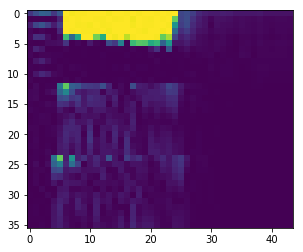

In [21]:
test_img = x_tr[0, 0, :, :]
plt.imshow(test_img)
plt.show()

## 4 Model

I tried roughly 30 different models with focus on newer architectures like residual networks, networks in networks, squeezing and expanding convolutions, but in the end a 5x-Conv-MaxPool worked best. I really wanted to replace the last Dense layers with AveragePooling. They give a little more insight to what's happening in comparison to the "black box"-model that results from dense layers. However it didn't work out as well. I'm guessing this is because spectrograms show a different abstraction of information in comparison to a regular photo showing one object.

In my tests the use of Elu replaced the need for Batch Normalization, which usually improves any model. I didn't include them for performance reasons.

In [22]:
datagen = ImageDataGenerator(width_shift_range=0.25)

In [27]:
conv_shape = Input(shape=input_dim).get_shape()

model = Sequential([
    InputLayer(input_shape=input_dim),
    Reshape(target_shape = (int(conv_shape [1]), int(conv_shape[2] * conv_shape[3]))),
    LSTM(500, return_sequences=True),
    LSTM(500, return_sequences=True),
    LSTM(500),
    Dense(500, activation="relu"),
    Dense(output_dim, activation="softmax")
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1, 36, 44)         0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 1584)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 500)            4170000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 500)            2002000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 500)               2002000   
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_4 (Dense)              (None, 106)               53106     
Total para

In [37]:
rnn_size = 160

input_tensor = Input(shape=input_dim)

x = input_tensor

conv_shape = x.get_shape()
x = Reshape(target_shape = (int(conv_shape [1]), int(conv_shape[2] * conv_shape[3])))(x)

    # Two layers of bidirectional GRUs
    # GRU seems to work as well, if not better than LSTM:
gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(x)
gru1_merged = add([gru_1, gru_1b])
gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
x = Dense(75, kernel_initializer='he_normal', name='dense2')(concatenate([gru_2, gru_2b]))
y_pred = Activation('softmax', name='softmax')(x)
Model(inputs=input_tensor, outputs=y_pred).summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_15 (InputLayer)            (None, 1, 36, 44)     0                                            
____________________________________________________________________________________________________
reshape_9 (Reshape)              (None, 1, 1584)       0           input_15[0][0]                   
____________________________________________________________________________________________________
gru1 (GRU)                       (None, 1, 160)        837600      reshape_9[0][0]                  
____________________________________________________________________________________________________
gru1_b (GRU)                     (None, 1, 160)        837600      reshape_9[0][0]                  
___________________________________________________________________________________________

In [38]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])
model.fit(x_tr, y_tr, epochs=2, verbose=1, validation_data=(x_va, y_va))



Train on 3738 samples, validate on 300 samples
Epoch 1/2
3738/3738 [==============================] - 7s - loss: 3.6940 - categorical_accuracy: 0.1110 - top_k_categorical_accuracy: 0.3692 - val_loss: 3.4066 - val_categorical_accuracy: 0.1067 - val_top_k_categorical_accuracy: 0.4133

In [39]:
#model = load_model('SpellingBee.h5')

In [39]:
#sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
#model.compile(loss='categorical_crossentropy', optimizer=Nadam(1e-6), metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])
#model.fit(x_tr, y_tr, epochs=15, verbose=1, validation_data=(x_va, y_va))

model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-3), metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])
model.fit(x_tr, y_tr, epochs=2, verbose=1, validation_data=(x_va, y_va))
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-4), metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])
model.fit(x_tr, y_tr, epochs=4, verbose=1, validation_data=(x_va, y_va))
model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])
model.fit(x_tr, y_tr, epochs=4, verbose=1, validation_data=(x_va, y_va))

Train on 3738 samples, validate on 300 samples
Epoch 1/2


KeyboardInterrupt: 

In [55]:
sgd = SGD(lr=0.1, decay=0.8, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])

In [56]:
datagen.fit(x_tr)
model.fit_generator(datagen.flow(x_tr, y_tr, batch_size=16),
                    steps_per_epoch=len(x_tr) / 16, epochs=15, 
                    validation_data=(x_va, y_va))

/home/daniel/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (3738, 12, 60, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Epoch 1/15
234/233 [==============================] - 2s - loss: 15.2932 - categorical_accuracy: 0.0446 - top_k_categorical_accuracy: 0.9869 - val_loss: 15.5808 - val_categorical_accuracy: 0.0333 - val_top_k_categorical_accuracy: 1.0000

In [57]:
model.evaluate(x_te, y_te)

288/300 [===========================>..] - ETA: 0s

[15.204736429850261, 0.056666666666666664, 1.0]

In [17]:
model.metrics_names

['loss', 'categorical_accuracy', 'top_k_categorical_accuracy']

In [ ]:
0.2200000011920929
0.185
model.predict(x_tr)

In [57]:
model.save('SpellingBee.h5')

In [ ]:
#!pip install -U coremltools
#import coremltools
#coreml_model = coremltools.converters.keras.convert('SpellingBee.h5')
#coreml_model.save('SpellingBee.mlmodel')